# HAMP comparison
This notebook shows a comparison of cloud features as detected by different parts of the Halo Microwave Package (HAMP) and includes data from WALES and specMACS for additional context.
Another application of the HAMP data is included in the chapter {doc}`unified`.

In [1]:
import numpy as np
import eurec4a
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

We'll define a helper-function to approximately convert cell centers to edges:

In [2]:
def center_to_edge(center):
    center = np.asarray(center)
    edge =  np.empty(center.shape[0]+1, dtype=center.dtype)
    # the strange notation in the following lines is used to make the calculations datetime compatible
    edge[1:-1] = center[1:] + (center[:-1] - center[1:])/2.
    edge[0] = edge[1] + (edge[1] - edge[2])
    edge[-1] = edge[-2] + (edge[-2] - edge[-3])
    return edge

And define a multi-linear scale that we will use for the LWP plot later on. This scale allows us to use zoom in a certain y-range. In our case, we will later increase the scale from 20 to 20 by a factor of 10.

In [3]:
import matplotlib as mpl
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    NullFormatter, ScalarFormatter,
    NullLocator, AutoLocator, AutoMinorLocator,
)

class MultiLinearTransform(Transform):
    input_dims = output_dims = 1
    is_separable = True

    def __init__(self, segments):
        super().__init__(self)
        self.segments = segments
        self.inverse_segments = [
            (
                self.transform_non_affine(np.array([p0]))[0],
                self.transform_non_affine(np.array([p1]))[0],
                1.0/scale
            )
            for (p0, p1, scale) in self.segments
        ]

    def transform_non_affine(self, a):
        result = a.copy().astype(float)
        with np.errstate(invalid="ignore"):
            for (p0, p1, scale) in self.segments:
                mask = np.logical_and(p0<a, a<=p1)
                result[mask] += (a[mask] - p0) * (scale - 1)
                result[p1<a] += (p1 - p0) * (scale - 1)
        return result

    def inverted(self):
        return MultiLinearTransform(self.inverse_segments)

class MultiLinearScale(ScaleBase):
    name = "multilinear"

    def __init__(self, axis, segments):
        """
        A MPL ax scale that magnifies given segments

        Parameters
        ----------
        axis : {matplotlib axis}
            The axis handle
        segments : {[tuples of 3-tuples]}
            Format: [(p0, p1, scale), ...]
            Magnify each segment from p0 to p1 by given scale factor.
            p0 <= p1

        Example
        -------
        ax.set_yscale('magnifylinear', segments=[[-20., 20., 10.]])

        """
        for (p0, p1, scale) in segments:
            if p0 > p1:
                raise ValueError("p0 must be less or equal p1")
            if scale <= 0:
                raise ValueError("scale must be positive")

        super().__init__(axis)
        self.segments = segments

    def get_transform(self):
        return MultiLinearTransform(self.segments)

    def set_default_locators_and_formatters(self, axis):
        # docstring inherited
        axis.set_major_locator(AutoLocator())
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_formatter(NullFormatter())
        # update the minor locator for x and y axis based on rcParams
        if (axis.axis_name == 'x' and mpl.rcParams['xtick.minor.visible'] or
                axis.axis_name == 'y' and mpl.rcParams['ytick.minor.visible']):
            axis.set_minor_locator(AutoMinorLocator())
        else:
            axis.set_minor_locator(NullLocator())

# register scale in matplotlib
register_scale(MultiLinearScale)

## Collect datasets
We want to look at data from several sensors within a spacific timeframe on flight `HALO-0205`:

In [4]:
flight_id = 'HALO-0205'
timeslice = slice('2020-02-05T13:07', '2020-02-05T13:11')

radiometer_cm = cat.HALO.UNIFIED.HAMPradiometer_cloudmask[flight_id].to_dask().sel(time=timeslice)
radar_cm = cat.HALO.UNIFIED.HAMPradar_cloudmask[flight_id].to_dask().sel(time=timeslice)

retrieval =  cat.HALO.UNIFIED.HAMPradiometer_retrievals[flight_id].to_dask().sel(time=timeslice)

radar = cat.HALO.UNIFIED.HAMPradar[flight_id].to_dask().sel(time=timeslice)
wales = cat.HALO.WALES.cloudparameter[flight_id].to_dask().sel(time=timeslice)
specMACS = cat.HALO.specMACS.cloudmaskSWIR[flight_id].to_dask().sel(time=timeslice)

/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArr

Ideally, we'd be handling the cloud flag meanings properly, but for now, let's just check if they are defined similarly:

In [5]:
assert np.all(radar_cm.cloud_mask.flag_values == radiometer_cm.cloud_mask.flag_values)
assert np.all(radar_cm.cloud_mask.flag_values == wales.cloud_mask.flag_values)
assert radar_cm.cloud_mask.flag_meanings == 'no_cloud_detectable probably_cloudy most_likely_cloudy'
assert radiometer_cm.cloud_mask.flag_meanings == 'no_cloud_detectable probably_cloudy most_likely_cloudy'
assert wales.cloud_mask.flag_meanings == 'cloud_free probably_cloudy most_likely_cloudy'

Let's prepare the radar reflectivity (dBZ) time-height plot. Get the dBZ in right shape and adjust the x and y axis according to the requirements of pcolormesh, this means x and y define the pixel edges in the respective direction. Also we convert the height coordinate from the WGS84 ellipsoid height to height above the Geoid. For this, we need y (and x) as 2D fields, as we have to correct the height in every time step as function of lat and lon. The Radar and Lidar cloud top heigh products are already defined above the Geoid or sea surface.

In [6]:
def wgs84_height(lon, lat):
    #TODO: find wgs84_height(lon, lat) function that works with the licence
    # this is a good average number for the EUREC4A circle area.
    return np.zeros_like(lon+lat) - 47.5

radar_dBZ = radar.dBZ.transpose('height', 'time').values
radar_x = center_to_edge(radar.time)
radar_y = center_to_edge(radar.height)
radar_x, radar_y = np.meshgrid(radar_x, radar_y)
wgs_correction = center_to_edge(wgs84_height(radar.lon, radar.lat))[np.newaxis, :]
radar_y = radar_y - wgs_correction

## Plot timeseries

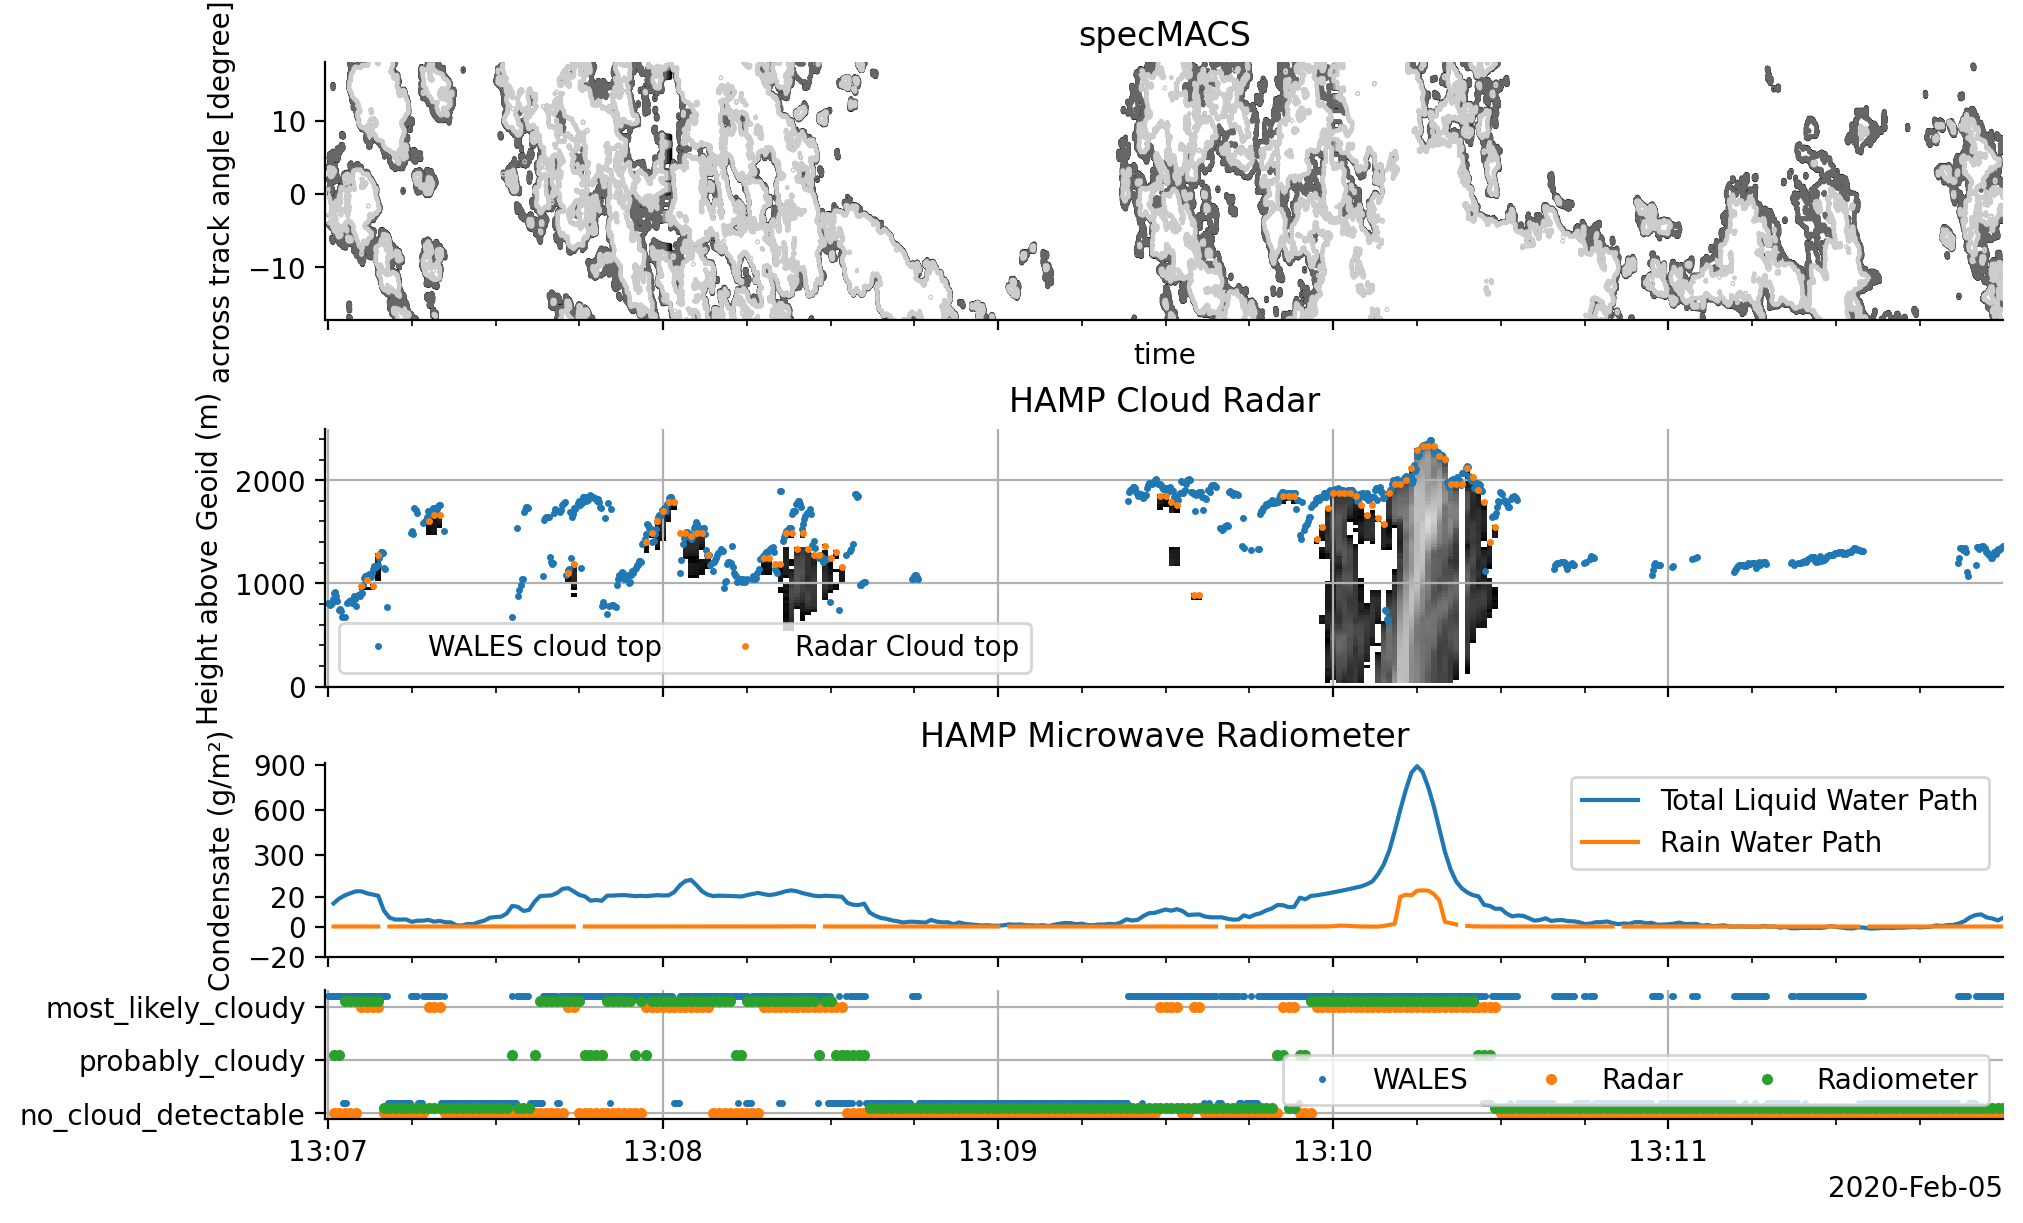

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
plt.style.use(pathlib.Path("./mplstyle/book"))

fig, (ax3, ax2, ax1, ax,) = plt.subplots(
    nrows=4, sharex=True,
    gridspec_kw=dict(height_ratios=[1, 1, .75, 0.5]),
)

ax.plot(wales.time, wales.cloud_mask + 0.2, '.', label='WALES', markersize=3)
ax.plot(radar_cm.time, radar_cm.cloud_mask, '.', label='Radar')
ax.plot(radiometer_cm.time, radiometer_cm.cloud_mask + 0.1, '.', label='Radiometer')

# Make nice labels
ax.set_yticks(radar_cm.cloud_mask.flag_values)
ax.set_yticklabels(radar_cm.cloud_mask.flag_meanings.split())
ax.legend(ncol=3, loc='lower right')
ax.grid()

# Plot Radar Curtain
ax2.set_title('HAMP Cloud Radar')
ax2.pcolormesh(radar_x, radar_y, radar_dBZ, vmin=-30, vmax=35, cmap='gray', rasterized=True)

ax2.plot(
     wales.time,  wales.cloud_top,
    '.', markersize=3,
    label='WALES cloud top'
)
ax2.plot(
    radar_cm.time, radar_cm.cloud_top,
    '.', markersize=3,
    label='Radar Cloud top'
)
ax2.set_ylabel('Height above Geoid (m)')
ax2.set_ylim(0, 2500)
ax2.grid()
ax2.legend(ncol=3)
ax2.minorticks_on()

# specMACS
specMACS.cloud_mask.T.plot.contour(ax=ax3, cmap="gray", add_colorbar=False)
ax3.set_title('specMACS')

# Plot MWR Retrievals
ax1.set_title('HAMP Microwave Radiometer')
ax1.plot(retrieval.time, retrieval.lwp*1000, label='Total Liquid Water Path')
ax1.plot(retrieval.time, retrieval.rwp*1000, label='Rain Water Path')
ax1.set_ylim(-10, 911)
ax1.legend()

ax1.set_yscale('multilinear', segments=[[-20., 20., 10.]])
#ax1.axhline(20, color='k', linewidth=1, linestyle=':', zorder=0)
ax1.set_yticks([-20, 0, 20, 300, 600, 900])
ax1.set_ylabel('Condensate (g/m²)')

#ax.set_xlim(np.datetime64(start), np.datetime64(end))
None